<a href="https://www.kaggle.com/code/dataqueen22/sallifort-motors-hr?scriptVersionId=148620493" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Capstone project: Providing data-driven suggestions for HR**

### Understand the business scenario and problem

The HR department at Salifort Motors wants to take some initiatives to improve employee satisfaction levels at the company. Provide data-driven suggestions based on understanding of the data. The HR department has the following question: what’s likely to make the employee leave the company?

### Familiarize yourself with the HR dataset

The dataset contains 15,000 rows and 10 columns for the variables listed below. 

Data Source source on [Kaggle](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv).

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

from xgboost import plot_importance
# This module lets us save our models once we fit them.
import pickle

In [2]:
# Load dataset into a dataframe
filepath="/kaggle/input/hr-analytics-and-job-prediction/HR_comma_sep.csv"
df0 = pd.read_csv(filepath)

# Display first few rows of the dataframe
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
# Gather basic information about the data
#df0.info()
print("Department")
print(df0["Department"].unique())
print("\nSalary")
print(df0["salary"].unique())

Department
['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD']

Salary
['low' 'medium' 'high']


### Gather descriptive statistics about the data

In [4]:
# Display all column names
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [5]:
# Rename columns as needed
df0.rename(columns={'average_montly_hours':'average_monthly_hours','Department': 'department', 'time_spend_company':'tenure','Work_accident': 'work_accident', 'left': 'employee_left'}, inplace=True)

# Display all column names after the update
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_monthly_hours  14999 non-null  int64  
 4   tenure                 14999 non-null  int64  
 5   work_accident          14999 non-null  int64  
 6   employee_left          14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### Check missing values

In [6]:
# Check for missing values
df0.isnull().sum()
df0.isnull().values.any()
#No Missing Values

False

### Check duplicates

In [7]:
# Check for duplicates
df1 = df0[df0.duplicated(keep='first')]
df1.shape
#df0.drop_duplicates().shape


(3008, 10)

In [8]:
# Inspect some rows containing duplicates as needed

df1.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,employee_left,promotion_last_5years,department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low


In [9]:
# Drop duplicates and save resulting dataframe in a new variable as needed
df=df0.drop_duplicates(keep='first')
df1=df.copy()

# Display first few rows of new dataframe as needed
df.head()
df.shape

(11991, 10)

### Check outliers

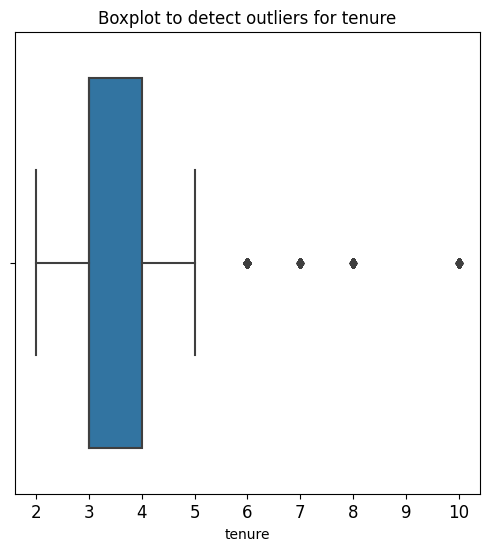

In [10]:
# Create a boxplot to visualize distribution of `tenure` and detect any outliers
plt.figure(figsize=(6,6))
plt.title('Boxplot to detect outliers for tenure', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df['tenure'])
plt.show()

In [11]:
# Determine the number of rows containing outliers
# Calculate the IQR
Q3 = np.quantile(df['tenure'], 0.75)
Q1 = np.quantile(df['tenure'], 0.25)
IQR_tenure = Q3 - Q1
 
lower_range = Q1 - 1.5 * IQR_tenure
upper_range = Q3 + 1.5 * IQR_tenure
print(lower_range)
print(upper_range)
#Identify subset of data containing outliers in `tenure`
outliers_tenure = df1[(df1['tenure'] > upper_range) | (df1['tenure'] < lower_range)]
print("Number of rows with outliers = " + str(len(outliers_tenure)))

1.5
5.5
Number of rows with outliers = 824


More the number of projects (>5) and more the average working hours => employee leaving the company.
Distribution of data = tenure has outliers 
Employees with > 7 projects - all left the company
M-F working dayes ~ 40 working hours ; In one year = 40*52 = 2080 hours or 2080/12 = 173 hours/month; However, average hours worked across employees ~ 200 ; Employees are definitely overworked - could be a reason to leave. 
"Histogram of average_montly_hours" = dual Peaks - Two sets of employees - one who have worked less than average hours (130-170 hours) and another who have worked (>230hours) First set may have been asked to go due and second set left because overworked.
Employees optimal number of projects worked : 3-4

In [12]:
# Get numbers of people who left vs. stayed
# Get percentages of people who left vs. stayed
print(str(df["employee_left"].value_counts(normalize=True)))
#Left 16.6% Stayed 83.3%

###['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT','product_mng' 'marketing' 'RandD']
# Create numeric `department_number` column
#department_dict = {'sales': 1,
#                  'accounting': 2,
#                  'hr': 3,
#                  'technical': 4,
#                  'support': 5,
#                 'management': 6,
#                'IT': 7,
#                'product_mng': 8,
#                'marketing': 9,
#                  'RandD': 10
#                }
#df['department_number'] = df['department'].replace(department_dict)

#Salary ['low' 'medium' 'high']
# Create numeric `salary_number` column
#salary_dict = {'low': 1,
#                  'medium': 2,
#                  'high': 3
#             }
#df['salary_number'] = df['salary'].replace(salary_dict)

#df = df.drop(columns=['salary','department'], axis=1)

df.info()

employee_left
0    0.833959
1    0.166041
Name: proportion, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Index: 11991 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     11991 non-null  float64
 1   last_evaluation        11991 non-null  float64
 2   number_project         11991 non-null  int64  
 3   average_monthly_hours  11991 non-null  int64  
 4   tenure                 11991 non-null  int64  
 5   work_accident          11991 non-null  int64  
 6   employee_left          11991 non-null  int64  
 7   promotion_last_5years  11991 non-null  int64  
 8   department             11991 non-null  object 
 9   salary                 11991 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.0+ MB


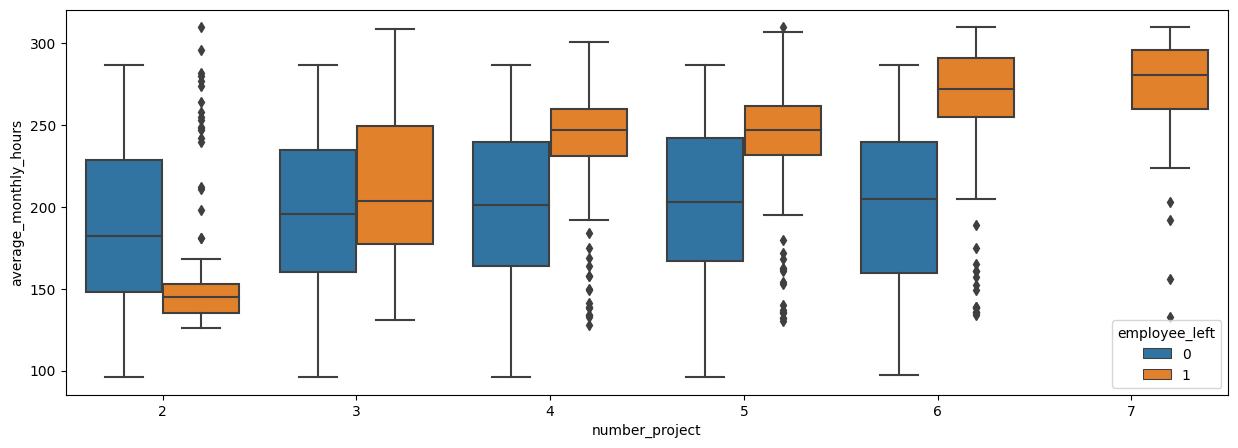

In [13]:
fig = plt.subplots(1, 1, figsize = (15,5))
sns.boxplot(data=df, x="number_project", y="average_monthly_hours", hue="employee_left")
plt.show()
#Employee left when average monthly hours were more

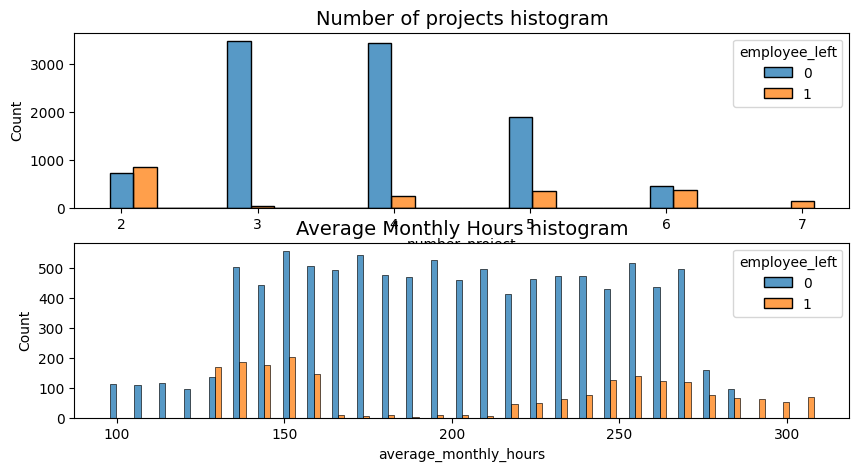

In [14]:
fig, axes  = plt.subplots(2, 1, figsize = (10,5))
# Create histogram showing distribution of `number_project`, comparing employees who stayed versus those who left
#tenure_stay = df[df['employee_left']==0]['number_project']
#tenure_left = df[df['employee_left']==1]['number_project']
fig = sns.histplot(data=df, x='number_project', hue='employee_left', multiple='dodge', shrink=2, ax=axes[0])
axes[0].set_title('Number of projects histogram', fontsize='14')

#tenure_stay = df[df['employee_left']==0]['average_monthly_hours']
#tenure_left = df[df['employee_left']==1]['average_monthly_hours']
fig = sns.histplot(data=df, x='average_monthly_hours', hue='employee_left', multiple='dodge', shrink=0.5, ax=axes[1])
axes[1].set_title('Average Monthly Hours histogram', fontsize='14')
plt.show()


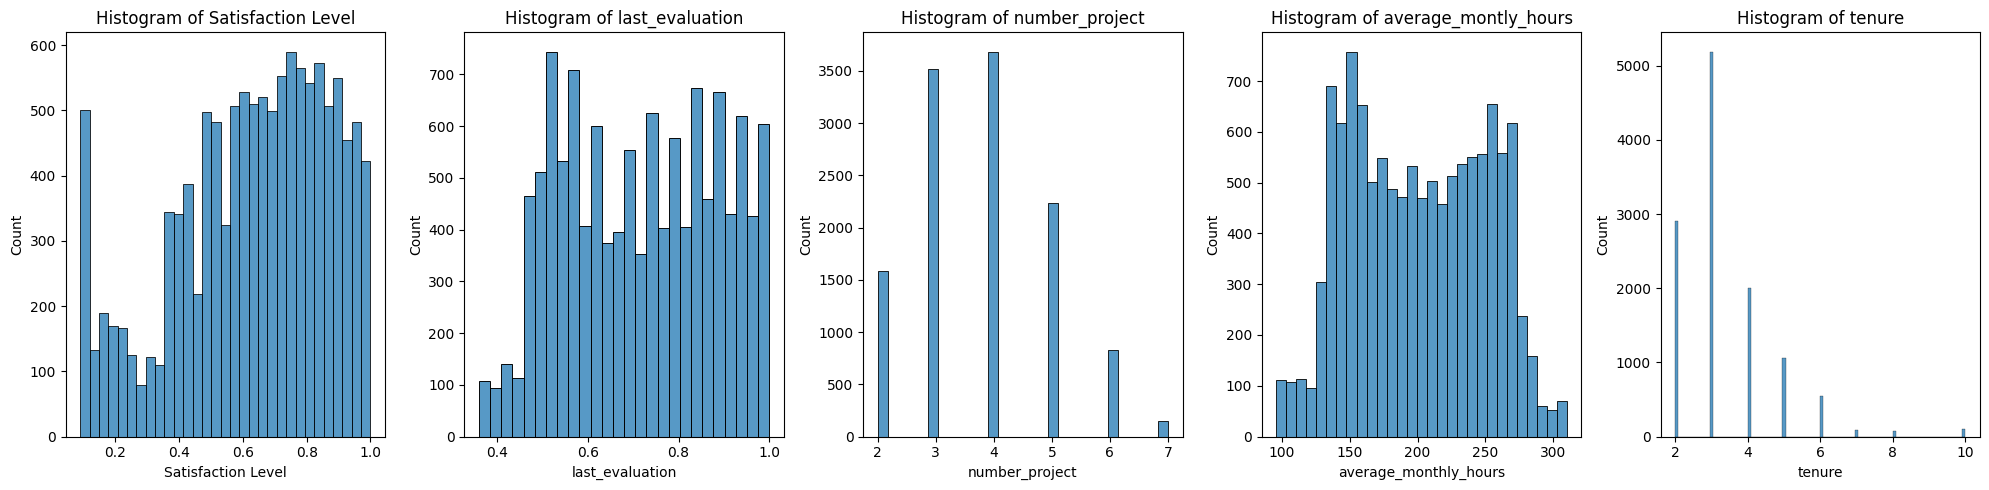

In [15]:

# Create a pairplot of the data.
#fig  = plt.subplots(2, 1, figsize = (10,5))
#sns.histplot(df,kind="hist",
#             x_vars=["tenure"],
#             y_vars=["number_project","average_monthly_hours"],
#             hue="employee_left")
#plt.show()

# Create a 1x5 plot figures.
fig, fig_qq = plt.subplots(1, 5, figsize = (20,5))

# Create a histogram with the Satisfaction Level. 
fig = sns.histplot(df["satisfaction_level"],ax=fig_qq[0])
# Set the x label of the residual plot.
fig_qq[0].set_xlabel("Satisfaction Level")
# Set the title of the residual plot.
fig_qq[0].set_title("Histogram of Satisfaction Level")
## Need to log of this for normalization

# Create a histogram with the last_evaluation. 
fig = sns.histplot(df["last_evaluation"],ax=fig_qq[1])
# Set the x label of the residual plot.
fig_qq[1].set_xlabel("last_evaluation")
# Set the title of the residual plot.
fig_qq[1].set_title("Histogram of last_evaluation")
## Need to log of this for normalization

# Create a histogram with the number_project. 
fig = sns.histplot(df["number_project"],ax=fig_qq[2])
# Set the x label of the residual plot.
fig_qq[2].set_xlabel("number_project")
# Set the title of the residual plot.
fig_qq[2].set_title("Histogram of number_project")
#Normalized distribution

# Create a histogram with the average_montly_hours. 
fig = sns.histplot(df["average_monthly_hours"],ax=fig_qq[3])
# Set the x label of the residual plot.
fig_qq[3].set_xlabel("average_monthly_hours")
# Set the title of the residual plot.
fig_qq[3].set_title("Histogram of average_montly_hours")
#dual Peaks - research further
             
# Create a histogram with the tenure. 
fig = sns.histplot(df["tenure"],ax=fig_qq[4])
 #hue='employee_left', multiple='dodge', shrink=0.5,
# Set the x label of the residual plot.
fig_qq[4].set_xlabel("tenure")
# Set the title of the residual plot.
fig_qq[4].set_title("Histogram of tenure")
#right skewed. 

# Use matplotlib's tight_layout() function to add space between plots for a cleaner appearance.
plt.tight_layout()
# Show the plot.
plt.show()

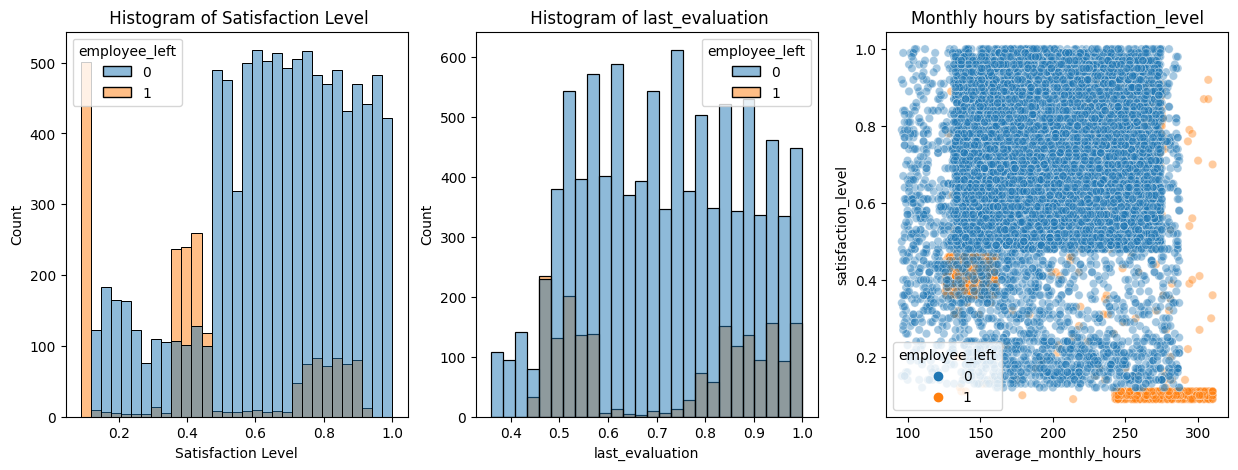

<Figure size 1600x900 with 0 Axes>

In [16]:
#log histogram of last evaluation vs employee left.
# Plot a histogram
# Create a 1x3 plot figures.
fig, fig_qq = plt.subplots(1, 3, figsize = (15,5))

# Create a histogram with the Satisfaction Level. 
fig = sns.histplot(data = df, x="satisfaction_level",hue='employee_left', ax=fig_qq[0])
# Set the x label of the residual plot.
fig_qq[0].set_xlabel("Satisfaction Level")
# Set the title of the residual plot.
fig_qq[0].set_title(" Histogram of Satisfaction Level")

# Create a histogram with the last_evaluation. 
fig = sns.histplot(data = df, x="last_evaluation",hue='employee_left',ax=fig_qq[1])
# Set the x label of the residual plot.
fig_qq[1].set_xlabel("last_evaluation")
# Set the title of the residual plot.
fig_qq[1].set_title(" Histogram of last_evaluation")
## Need to log of this for normalization

# Create scatterplot of `average_monthly_hours` versus `satisfaction_level`, comparing employees who stayed versus those who left
plt.figure(figsize=(16, 9))
fig = sns.scatterplot(data=df, x='average_monthly_hours', y='satisfaction_level', hue='employee_left', alpha=0.4,ax=fig_qq[2])
#plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
#fig_qq[2].set_label('166.67 hrs./mo.', 'employee_left', 'stayed'])
fig_qq[2].set_title('Monthly hours by satisfaction_level')

# Use matplotlib's tight_layout() function to add space between plots for a cleaner appearance.
plt.tight_layout()
# Show the plot.
plt.show()

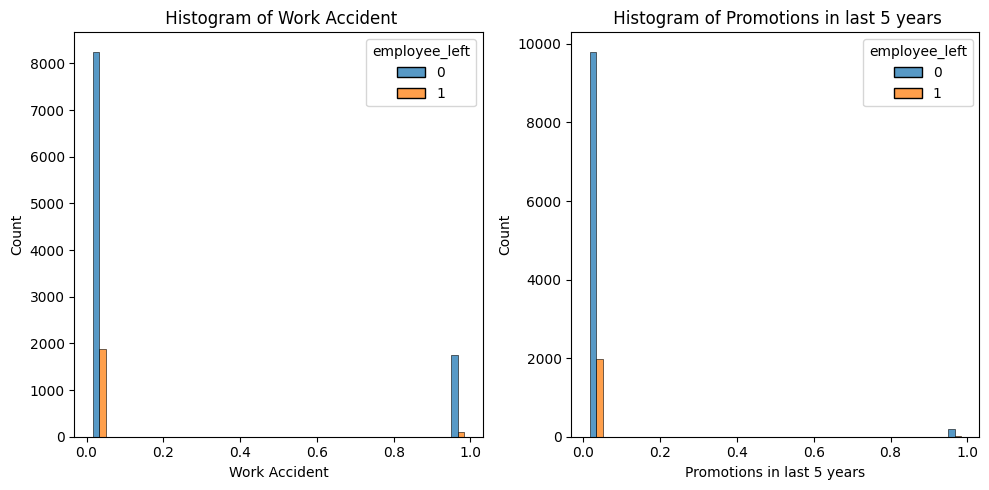

In [17]:
# Create a 1x2 plot figures.
fig, fig_qq = plt.subplots(1, 2, figsize = (10,5))

# Create a histogram with the Satisfaction Level. 
fig = sns.histplot(data = df, x="work_accident",hue='employee_left', multiple='dodge', shrink=0.5, ax=fig_qq[0])
# Set the x label of the residual plot.
fig_qq[0].set_xlabel("Work Accident")
# Set the title of the residual plot.
fig_qq[0].set_title(" Histogram of Work Accident")
# Very few employees left due to accident at work. 

# Create a histogram with the last_evaluation. 
fig = sns.histplot(data = df, x="promotion_last_5years",hue='employee_left',multiple='dodge', shrink=0.5, ax=fig_qq[1])
# Set the x label of the residual plot.
fig_qq[1].set_xlabel("Promotions in last 5 years")
# Set the title of the residual plot.
fig_qq[1].set_title(" Histogram of Promotions in last 5 years")
## Promotions in last 5 years has had no impact on employees leaving

# Use matplotlib's tight_layout() function to add space between plots for a cleaner appearance.
plt.tight_layout()
# Show the plot.
plt.show()

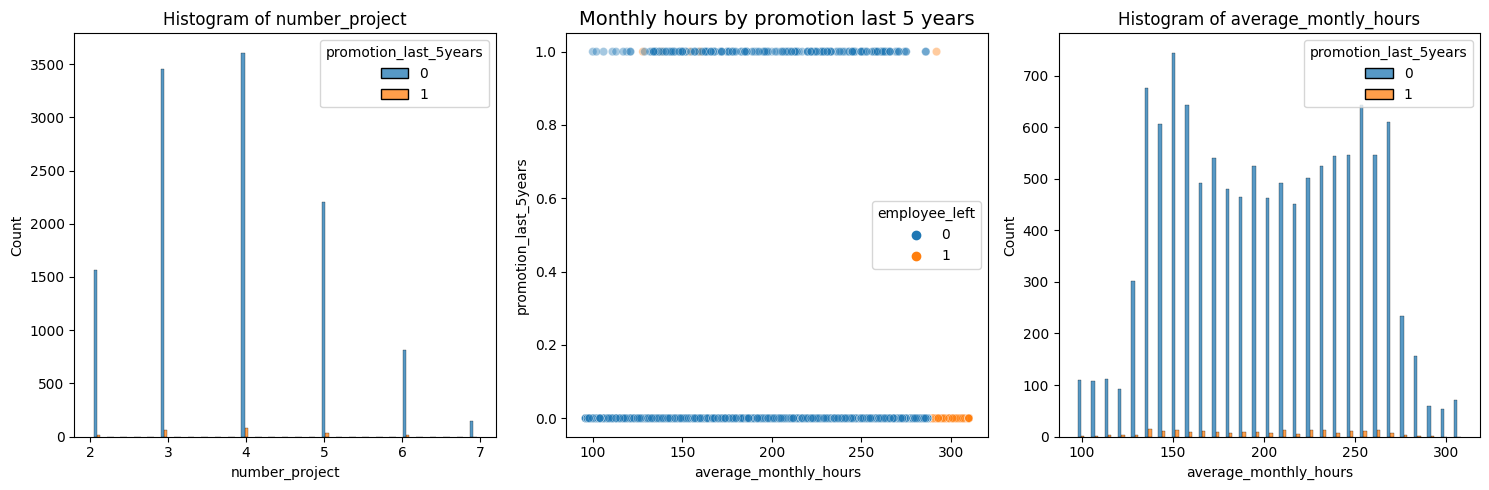

In [18]:
#relation ship between average hours worked n promotions in last 5 years as histogram
# Create a histogram with the number_project. 
# Create a 1x3 plot figures.
fig, fig_qq = plt.subplots(1, 3, figsize = (15,5))

fig = sns.histplot(data = df, x="number_project",hue='promotion_last_5years',multiple='dodge', shrink=0.5, ax=fig_qq[0])
# Set the x label of the residual plot.
fig_qq[0].set_xlabel("number_project")
# Set the title of the residual plot.
fig_qq[0].set_title("Histogram of number_project")
#Normalized distribution

# Create a scatter plot with the average_montly_hours. 
# Create plot to examine relationship between `average_monthly_hours` and `promotion_last_5years`
fig = sns.scatterplot(data=df, x='average_monthly_hours', y='promotion_last_5years', hue='employee_left', alpha=0.4,ax=fig_qq[1])
fig_qq[1].set_title('Monthly hours by promotion last 5 years', fontsize='14');

fig = sns.histplot(data = df, x="average_monthly_hours",hue='promotion_last_5years',multiple='dodge', shrink=0.5,ax=fig_qq[2])
# Set the x label of the residual plot.
fig_qq[2].set_xlabel("average_monthly_hours")
# Set the title of the residual plot.
fig_qq[2].set_title("Histogram of average_montly_hours")
# Use matplotlib's tight_layout() function to add space between plots for a cleaner appearance.
plt.tight_layout()
# Show the plot.
plt.show()


/tmp/ipykernel_20/2389707793.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['salary'] = (


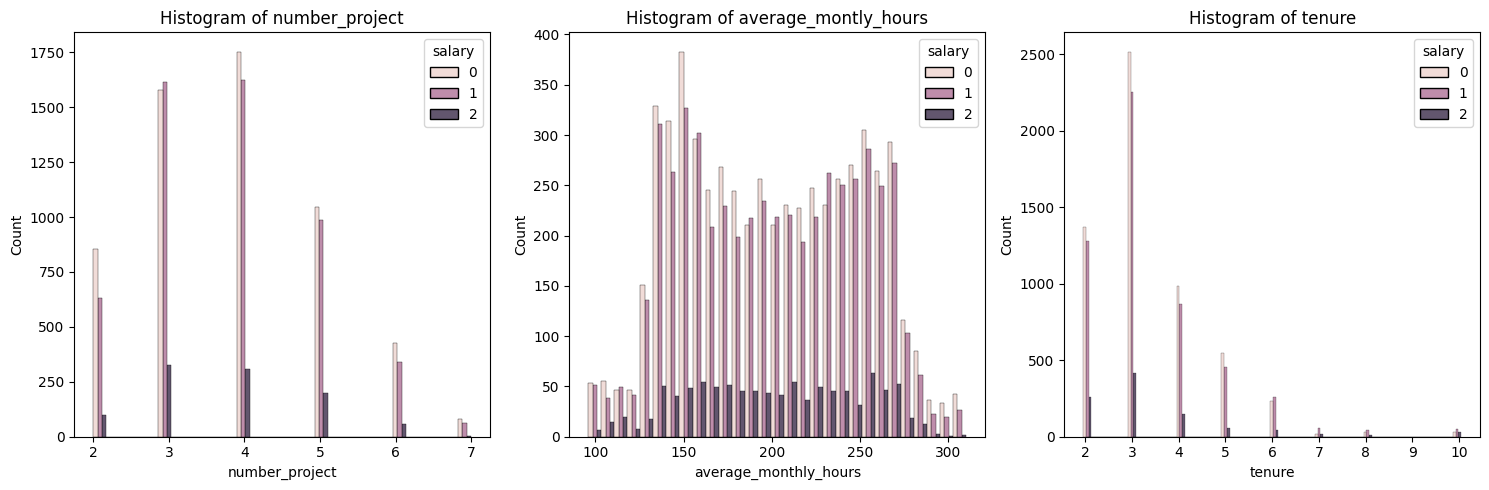

In [19]:
# Create a plot as needed salary_number
#relation ship between average hours worked n salary_number as histogram
# Create a histogram with the number_project. 
# Create a 1x3 plot figures.
# Encode the `salary` column as an ordinal numeric category
df['salary'] = (
    df0['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

# Dummy encode the `department` column
df = pd.get_dummies(df, drop_first=False)

# Display the new dataframe
#df.head()

fig, fig_qq = plt.subplots(1, 3, figsize = (15,5))

fig = sns.histplot(data = df, x="number_project",hue='salary',multiple='dodge', shrink=1, ax=fig_qq[0])
# Set the x label of the residual plot.
fig_qq[0].set_xlabel("number_project")
# Set the title of the residual plot.
fig_qq[0].set_title("Histogram of number_project")
#Normalized distribution

# Create a histogram with the average_montly_hours. 
fig = sns.histplot(data = df, x="average_monthly_hours",hue='salary',multiple='dodge', shrink=1,ax=fig_qq[1])
# Set the x label of the residual plot.
fig_qq[1].set_xlabel("average_monthly_hours")
# Set the title of the residual plot.
fig_qq[1].set_title("Histogram of average_montly_hours")

# Create a histogram with the tenure. 
fig = sns.histplot(data = df, x="tenure",hue='salary',multiple='dodge', shrink=2,ax=fig_qq[2])
# Set the x label of the residual plot.
fig_qq[2].set_xlabel("tenure")
# Set the title of the residual plot.
fig_qq[2].set_title("Histogram of tenure")
#Very few low salary in 10 year tensure. Low salary mostly 2-5 years; Medium - 2-6 years ; High 10 years.

# Use matplotlib's tight_layout() function to add space between plots for a cleaner appearance.
plt.tight_layout()
# Show the plot.
plt.show()

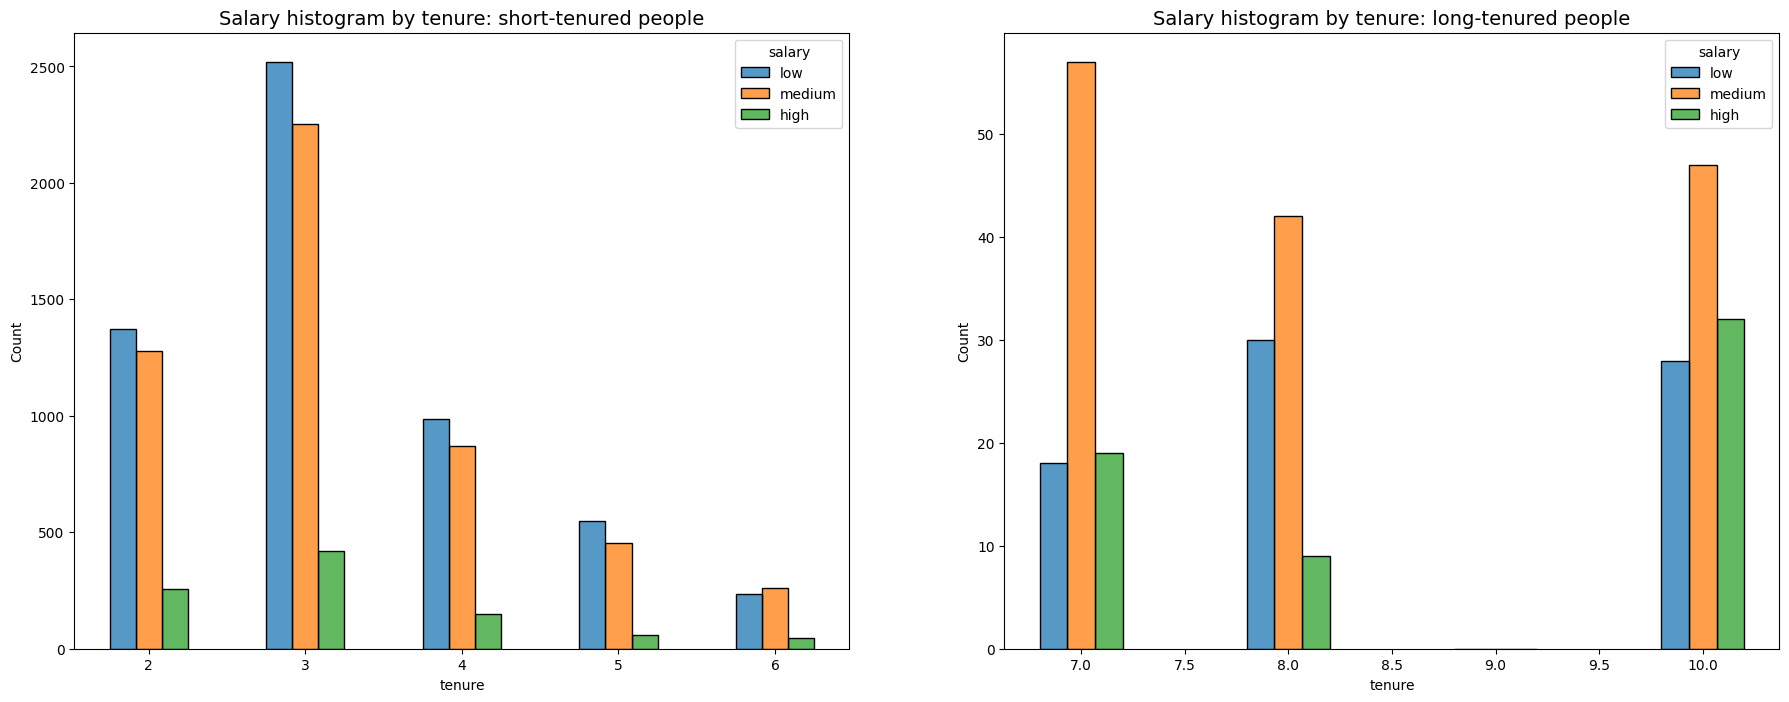

In [20]:
# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Define short-tenured employees
tenure_short = df1[df1['tenure'] < 7]

# Define long-tenured employees
tenure_long = df1[df1['tenure'] > 6]

# Plot short-tenured histogram
sns.histplot(data=tenure_short, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5, ax=ax[0])
ax[0].set_title('Salary histogram by tenure: short-tenured people', fontsize='14')

# Plot long-tenured histogram
sns.histplot(data=tenure_long, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.4, ax=ax[1])
ax[1].set_title('Salary histogram by tenure: long-tenured people', fontsize='14');


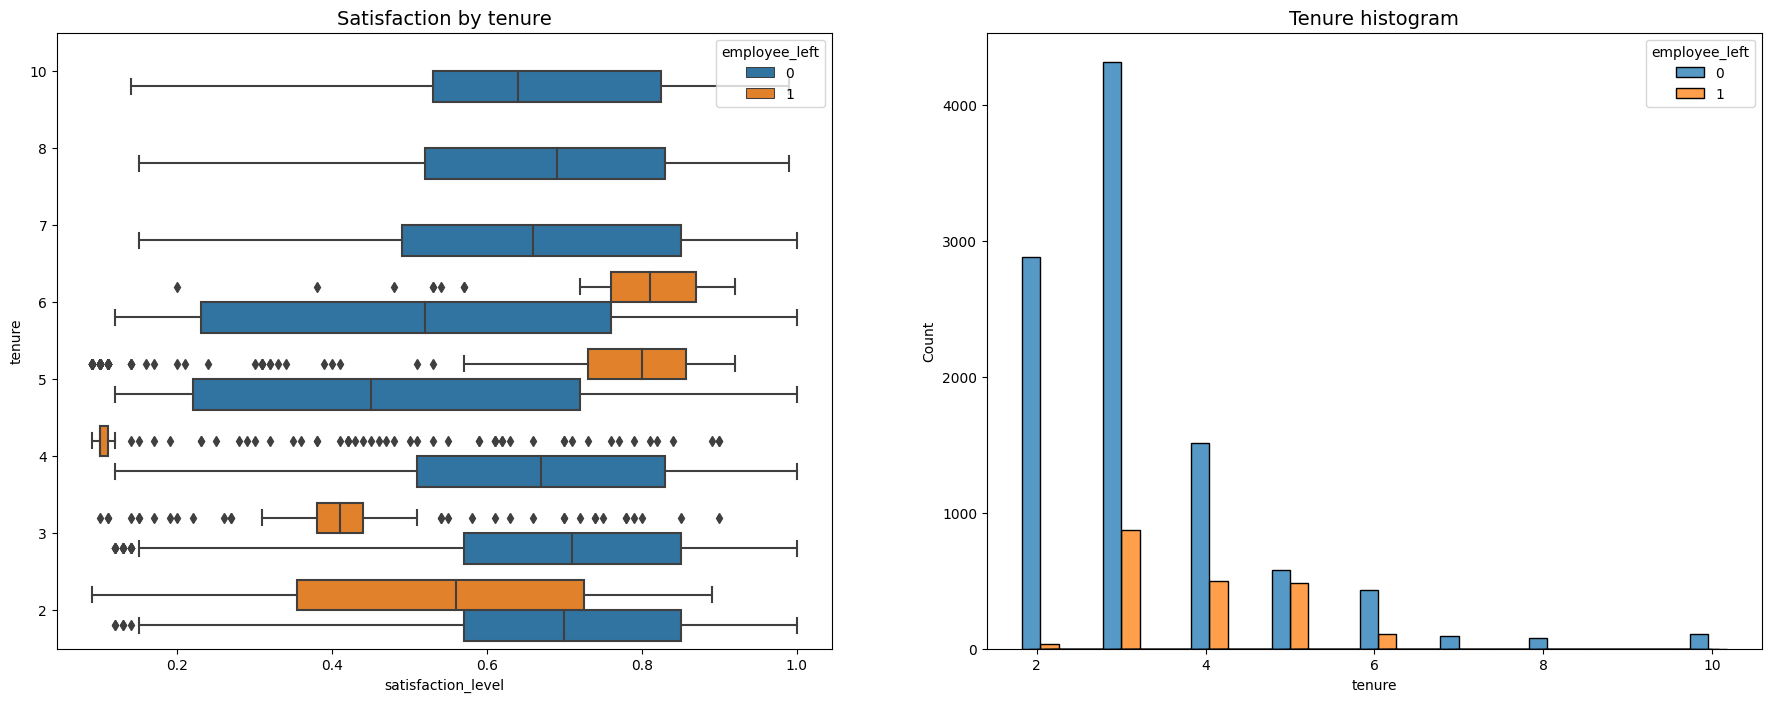

In [21]:
# Create a 1x3 plot figures.
# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Create boxplot showing distributions of `satisfaction_level` by tenure, comparing employees who stayed versus those who left
sns.boxplot(data=df1, x='satisfaction_level', y='tenure', hue='employee_left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize='14')

# Create histogram showing distribution of `tenure`, comparing employees who stayed versus those who left
#tenure_stay = df1[df1['left']==0]['tenure']
#tenure_left = df1[df1['left']==1]['tenure']
sns.histplot(data=df1, x='tenure', hue='employee_left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Tenure histogram', fontsize='14')

plt.show();

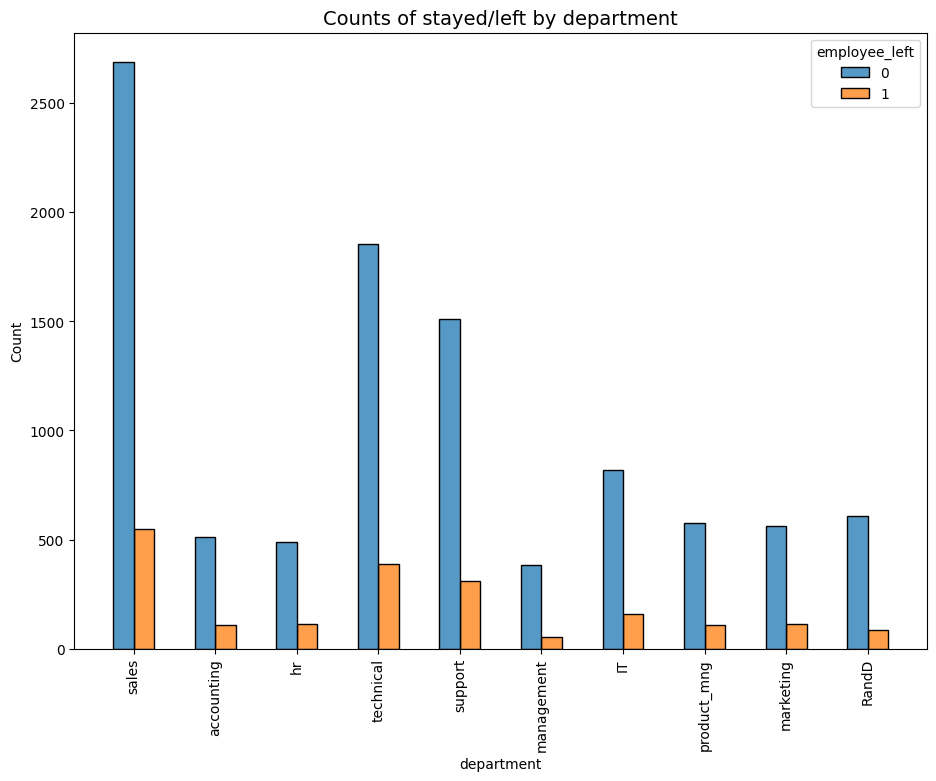

In [22]:
# Create stacked histogram to compare department distribution of employees who left to that of employees who didn't
#df1 data set has departments by name and not  number

plt.figure(figsize=(11,8))
sns.histplot(data=df1, x='department', hue='employee_left', discrete=1, 
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation='vertical')
plt.title('Counts of stayed/left by department', fontsize=14);


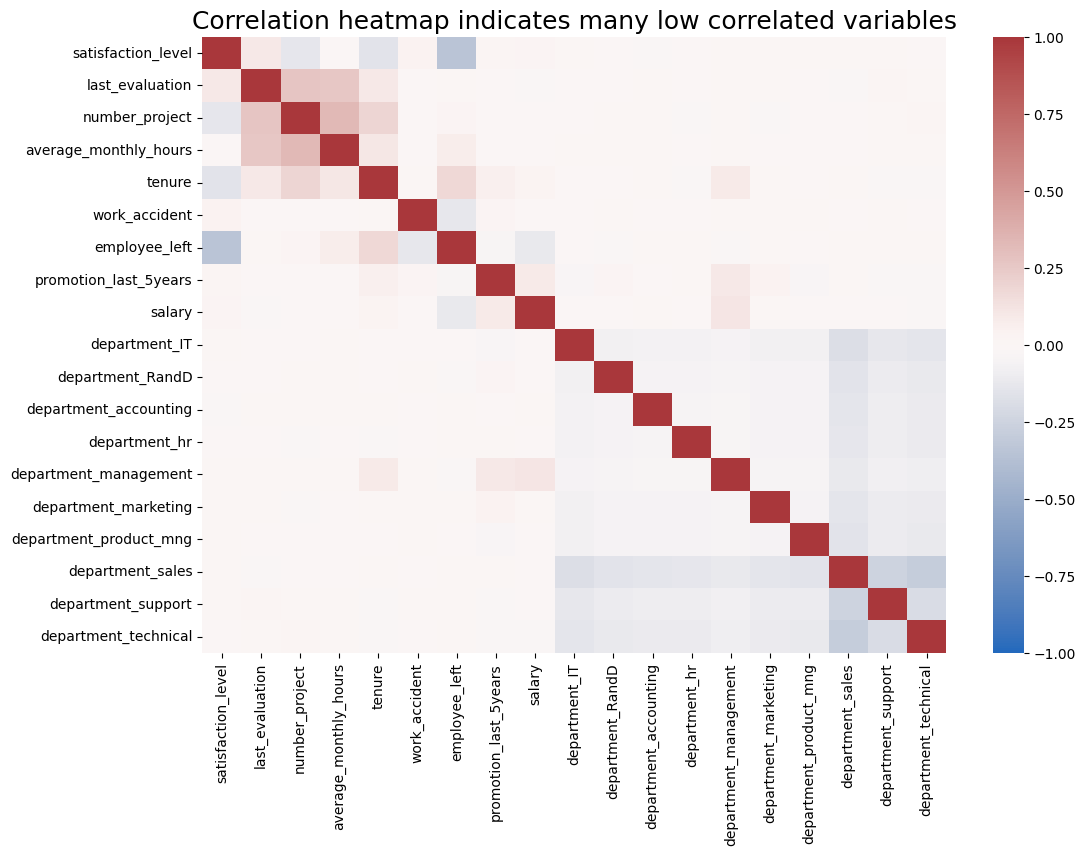

In [23]:
# Plot a correlation heatmap
# Generate a correlation matrix
import seaborn as sns
corr = df.corr(method='pearson')
plt.figure(figsize=(12,8))
sns.heatmap(corr, vmin=-1, vmax=1, annot=False,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           cmap=sns.color_palette("vlag", as_cmap=True))
plt.title('Correlation heatmap indicates many low correlated variables',
          fontsize=18)
plt.show();

### Insights

Employees who left fall into two general categories: dissatisfied employees with shorter tenures and very satisfied employees with medium-length tenures.
Four-year employees who left seem to have an unusually low satisfaction level. It's worth investigating changes to company policy that might have affected people specifically at the four-year mark, if possible.
The longest-tenured employees didn't leave. Their satisfaction levels aligned with those of newer employees who stayed.
The histogram shows that there are relatively few longer-tenured employees. It's possible that they're the higher-ranking, higher-paid employees.

- very few employees who were promoted in the last five years left
- very few employees who worked the most hours were promoted
- all of the employees who left were working the longest hours

Also, number of projects, monthly hours, and evaluation scores all have some positive correlation with each other, and whether an employee leaves is negatively correlated with their satisfaction level.

Model - Logistic regression models a categorical variable based on one or more independent variables. The dependent variable can have two or more possible discrete values. Categorical variable - employee_left ; 
Independent Variable - 'satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure'

### Modeling


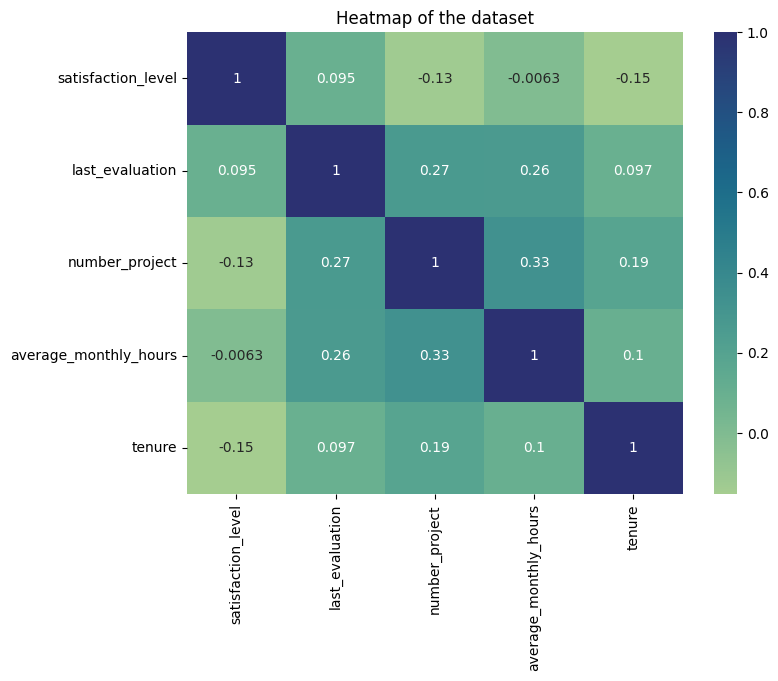

In [24]:

plt.figure(figsize=(8, 6))
sns.heatmap(df[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']]
            .corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

In [25]:
#Logistic regression model 
# Three other assumptions of binomial logistic regression.
#Independent observations - DONE 
#We assume that there is little to no multicore linearity between the independent variables. If we include multiple X variables, they should not be highly correlated with one another, just like with linear regression.
#Lastly, we assume that there are no extreme outliers in the dataset. REMOVE THE OUTLIERS TENURE 
# Select rows without outliers in `tenure` and save resulting dataframe in a new variable
lower_limit = min(df['tenure'])
print(lower_limit)
upper_limit = 6
print(upper_limit)
df_logreg = df[(df['tenure'] >= lower_limit) & (df['tenure'] <= upper_limit)]

# Display first few rows of new dataframe no outliers present
df_logreg.head()

2
6


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,employee_left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [26]:
#build the model
# Isolate the outcome variable
y = df_logreg['employee_left']
# Select the features you want to use in your model
X = df_logreg.drop('employee_left', axis=1)
# Split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
# Construct a logistic regression model and fit it to the training dataset
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)
# Use the logistic regression model to get predictions on the test set
y_pred = log_clf.predict(X_test)

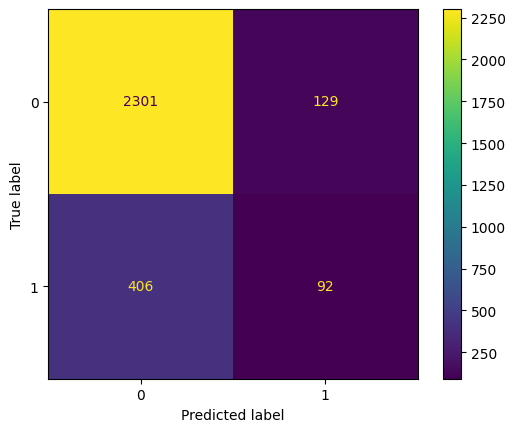

In [27]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)
# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)
# Plot confusion matrix
log_disp.plot(values_format='')
# Display plot
plt.show()

TN-FP
FN-TP

TN: The number of people who did not leave that the model accurately predicted did not leave.(2301)

FP: The number of people who did not leave the model inaccurately predicted as leaving.(129)

FN: The number of people who left that the model inaccurately predicted did not leave.(406)

TP: The number of people who left the model accurately predicted as leaving.(92)


In [28]:
df_logreg['employee_left'].value_counts(normalize=True)
# Create classification report for logistic regression model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.85      0.95      0.90      2430
    Predicted would leave       0.42      0.18      0.26       498

                 accuracy                           0.82      2928
                macro avg       0.63      0.57      0.58      2928
             weighted avg       0.78      0.82      0.79      2928



In [29]:
#Decision Tree 
# Isolate the outcome variable
y = df['employee_left']
# Select the features
X = df.drop('employee_left', axis=1)
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)
# Instantiate model
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [30]:
%%time
tree1.fit(X_train, y_train)

CPU times: user 4.48 s, sys: 3.75 ms, total: 4.49 s
Wall time: 4.49 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'precision', 'accuracy', 'recall', 'f1', 'roc_auc'})

In [31]:
print(" Best Params " + str(tree1.best_params_))
print(" \nAUC " + str(tree1.best_score_))

 Best Params {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}
 
AUC 0.969819392792457


Strong AUC score, which shows that this model can predict employees who will leave very well. AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0

In [32]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
  
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

In [33]:
# Get all CV scores
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.914552,0.916949,0.915707,0.971978,0.969819


In [34]:
#Random Forest 1
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [35]:
%%time
rf1.fit(X_train, y_train) # --> Wall time: ~10min

CPU times: user 28min 22s, sys: 3.18 s, total: 28min 25s
Wall time: 28min 26s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'precision', 'accuracy', 'recall', 'f1', 'roc_auc'})

In [36]:
# Define a path to the folder where you want to save the model
path = '/kaggle/working/'
def write_pickle(path, model_object, save_as:str):
    '''
    In: 
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''    

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

def read_pickle(path, saved_model_name:str):
    '''
    In: 
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out: 
        model: the pickled model 
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [37]:
#Write rf1 model 
# Write pickle
write_pickle(path, rf1, 'hr_rf1')
#read model 
# Read pickle
rf1 = read_pickle(path, 'hr_rf1')

In [38]:
print("AUC " + str(rf1.best_score_))
print("\nBest params " + str(rf1.best_params_))

AUC 0.9804250949807172

Best params {'max_depth': 5, 'max_features': 1.0, 'max_samples': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 500}


In [39]:
#get best scores, params, n store the result
# Check best AUC score on CV
# Get all CV scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.914552  0.916949  0.915707  0.971978  0.969819
              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.950023  0.915614  0.932467  0.977983  0.980425


Random forest AUC is better than the Decision Tree model.

In [40]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })
  
    return table

In [41]:
# Get predictions on test data
rf1_test_scores = get_scores('random forest1 test', rf1, X_test, y_test)
rf1_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest1 test,0.964211,0.919679,0.941418,0.980987,0.956439


The test scores are very similar to the validation scores, which is good. This appears to be a strong model. Since this test set was only used for this model, you can be more confident that your model's performance on this data is representative of how it will perform on new, unseeen data.



## FEATURE ENGINEERING - CREATING EXTRA FEATURE 

In [42]:
# Drop `satisfaction_level` and save resulting dataframe in new variable
df2 = df.drop('satisfaction_level', axis=1)
# Create `overworked` column. For now, it's identical to average monthly hours.
df2['overworked'] = df2['average_monthly_hours']

# Inspect max and min average monthly hours values
print('Max hours:', df2['overworked'].max())
print('Min hours:', df2['overworked'].min())
# Define `overworked` as working > 175 hrs/week
df2['overworked'] = (df2['overworked'] > 175).astype(int)

# Drop the `average_monthly_hours` column
df2 = df2.drop('average_monthly_hours', axis=1)

# Display first few rows of resulting dataframe
df2.head()

Max hours: 310
Min hours: 96


,last_evaluation,number_project,tenure,work_accident,employee_left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0
1,0.86,5,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
2,0.88,7,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
3,0.87,5,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False,1
4,0.52,2,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0


In [43]:
# Isolate the outcome variable
y = df2['employee_left']

# Select the features
X = df2.drop('employee_left', axis=1)
# Create test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)
# Instantiate model
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
tree2 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [44]:
%%time
tree2.fit(X_train, y_train)

CPU times: user 3.59 s, sys: 5 ms, total: 3.59 s
Wall time: 3.59 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'precision', 'accuracy', 'recall', 'f1', 'roc_auc'})

In [45]:
# Check best params
print(tree2.best_params_)
# Check best AUC score on CV
print(tree2.best_score_)
# Get all CV scores
tree2_cv_results = make_results('decision tree2 cv', tree2, 'auc')
print(tree1_cv_results)
print(tree2_cv_results)

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}
0.9586752505340426
              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.914552  0.916949  0.915707  0.971978  0.969819
               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.856693  0.903553  0.878882  0.958523  0.958675


In [46]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [47]:
%%time
rf2.fit(X_train, y_train) # --> Wall time: 7min 5s

CPU times: user 20min 25s, sys: 2.63 s, total: 20min 28s
Wall time: 20min 28s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'precision', 'accuracy', 'recall', 'f1', 'roc_auc'})

In [48]:
# Write pickle
write_pickle(path, rf2, 'hr_rf2')
# Read in pickle
rf2 = read_pickle(path, 'hr_rf2')
# Check best params
print(rf2.best_params_)
# Check best AUC score on CV
print(rf2.best_score_)
# Get all CV scores
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')
print(tree2_cv_results)
print(rf2_cv_results)

{'max_depth': 5, 'max_features': 1.0, 'max_samples': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
0.9648100662833985
               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.856693  0.903553  0.878882  0.958523  0.958675
               model  precision    recall        F1  accuracy      auc
0  random forest2 cv   0.866758  0.878754  0.872407  0.957411  0.96481


In [49]:
# Get predictions on test data
rf2_test_scores = get_scores('random forest2 test', rf2, X_test, y_test)
rf2_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest2 test,0.870406,0.903614,0.8867,0.961641,0.938407


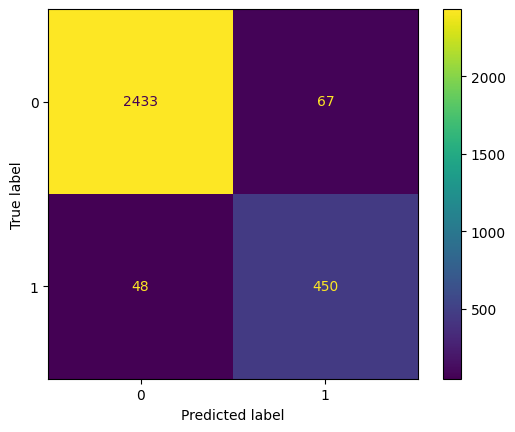

In [50]:
# Generate array of values for confusion matrix
preds = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf2.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2.classes_)
disp.plot(values_format='');

TN-FP
FN-TP

TN: The number of people who did not leave that the model accurately predicted did not leave.(2433)

FP: The number of people who did not leave the model inaccurately predicted as leaving.(67)

FN: The number of people who left that the model inaccurately predicted did not leave.(45)

TP: The number of people who left the model accurately predicted as leaving.(453)
The model predicts more false positives than false negatives, which means that some employees may be identified as at risk of quitting or getting fired, when that's actually not the case. But this is still a strong model.



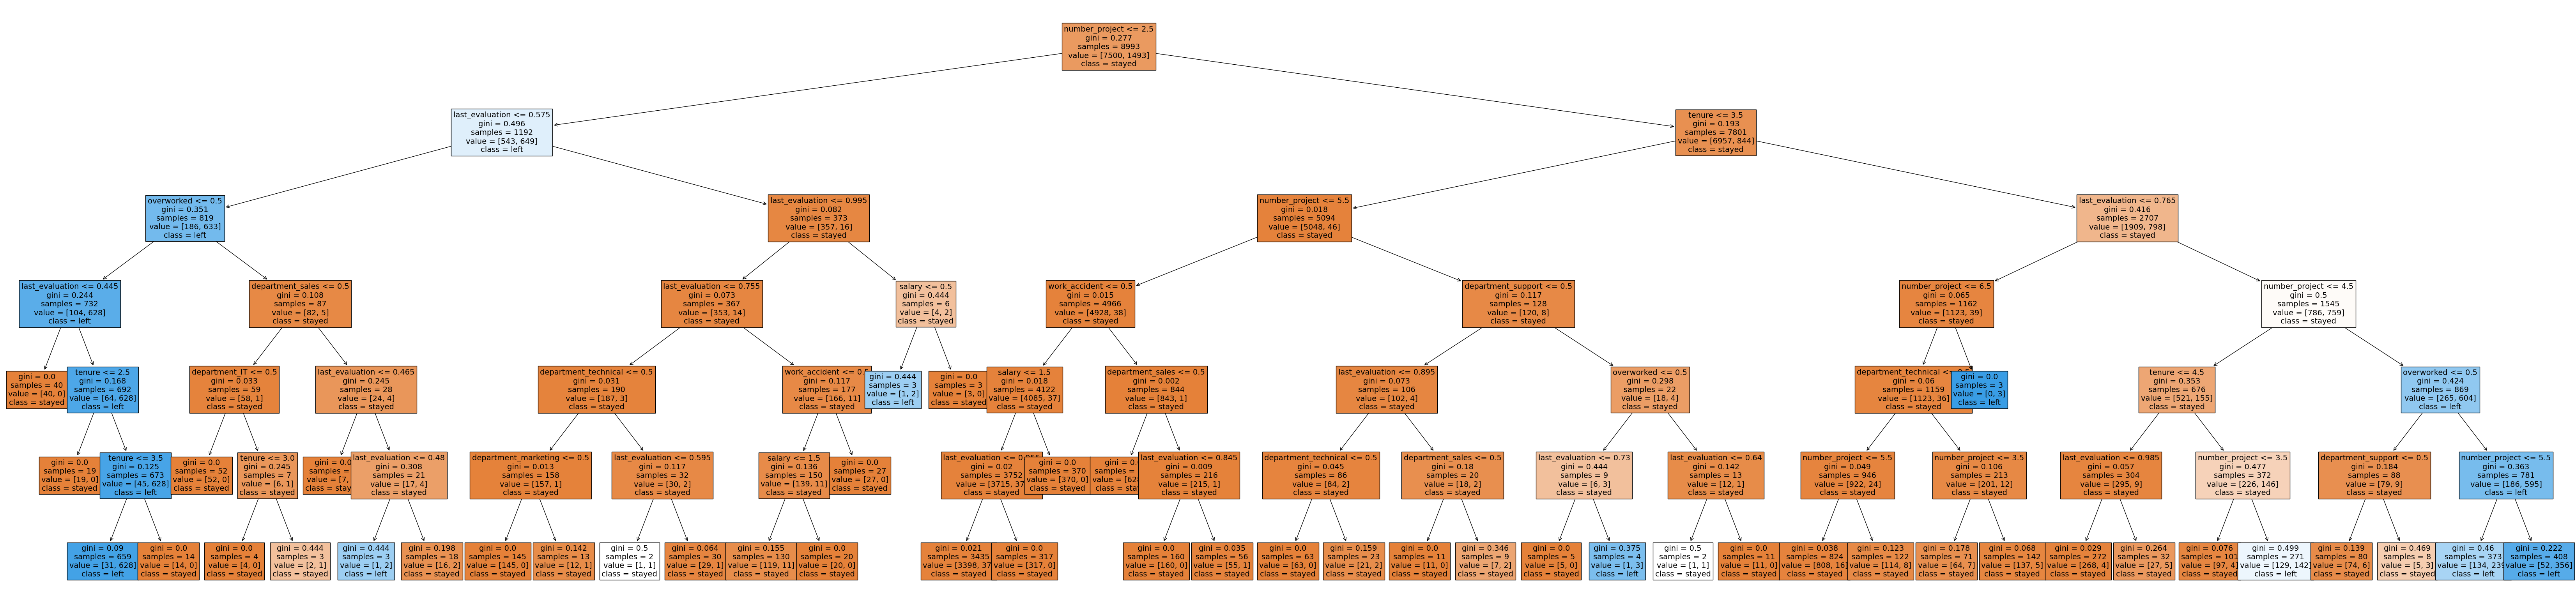

In [51]:
# Plot the tree
plt.figure(figsize=(85,20))
plot_tree(tree2.best_estimator_, max_depth=6, fontsize=14, feature_names=X.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

In [52]:
#tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, columns=X.columns)
tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
tree2_importances

,gini_importance
last_evaluation,0.343958
number_project,0.343385
tenure,0.215681
overworked,0.093498
department_support,0.001142
salary,0.000910
department_sales,0.000607
department_technical,0.000418
work_accident,0.000183
department_IT,0.000139


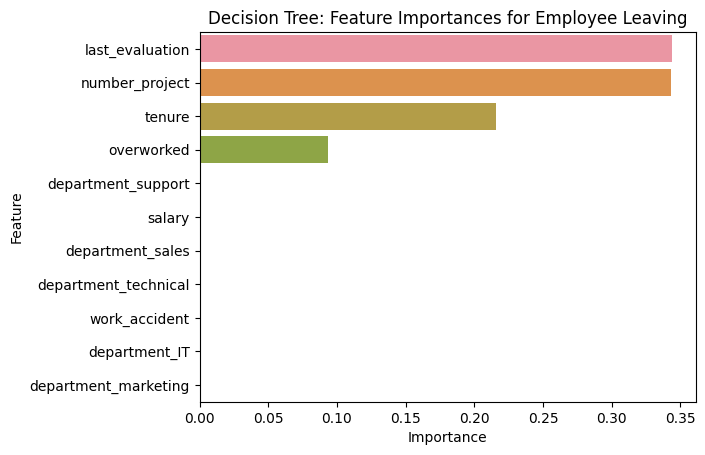

In [53]:
sns.barplot(data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

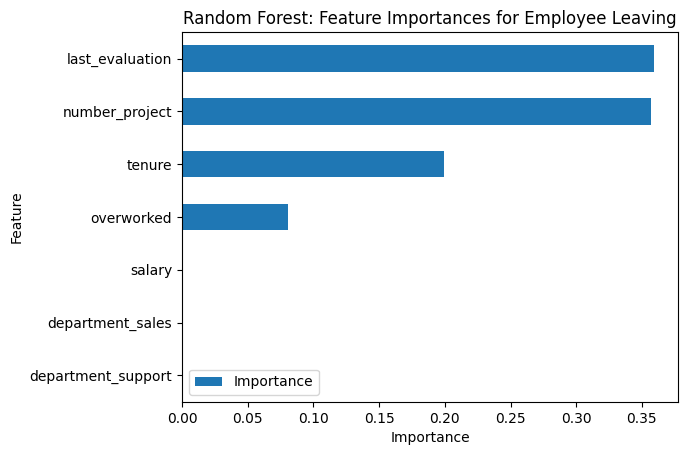

In [54]:
# Get feature importances
feat_impt = rf2.best_estimator_.feature_importances_

# Get indices of top 7 features
ind = np.argpartition(rf2.best_estimator_.feature_importances_, -7)[-7:]

# Get column labels of top 7 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 7 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

✏
## Evaluation metrics

- **AUC** is the area under the ROC curve; it's also considered the probability that the model ranks a random positive example more highly than a random negative example.
- **Precision** measures the proportion of data points predicted as True that are actually True, in other words, the proportion of positive predictions that are true positives.
- **Recall** measures the proportion of data points that are predicted as True, out of all the data points that are actually True. In other words, it measures the proportion of positives that are correctly classified.
- **Accuracy** measures the proportion of data points that are correctly classified.
- **F1-score** is an aggregation of precision and recall.






### Summary of model results

Logistic Regression

The logistic regression model achieved precision of 80%, recall of 83%, f1-score of 80% (all weighted averages), and accuracy of 83%, on the test set.

Tree-based Machine Learning

After conducting feature engineering, the decision tree model achieved AUC of 93.8%, precision of 87.0%, recall of 90.4%, f1-score of 88.7%, and accuracy of 96.2%, on the test set. The random forest modestly outperformed the decision tree model.

### Conclusion, Recommendations, Next Steps

The models and the feature importances extracted from the models confirm that employees at the company are overworked.

Recommendations - 
Limit the number of projects that employees can work on.
Limit working longer hours or give incentives/rewards/perks for employees who are working longer hours
Consider promoting employees who have been with the company for atleast four years, or conduct further investigation about why four-year tenured employees are so dissatisfied.
If employees aren not familiar with the companys overtime pay policies, inform them about this. If the expectations around workload and time off aren not explicit, make them clear.
Hold company-wide and within-team discussions to understand and address the company work culture, across the board and in specific contexts.
High evaluation scores should not be reserved for employees who work 200+ hours per month. Consider a proportionate scale for rewarding employees who contribute more/put in more effort.
